In [58]:
import numpy as np
import pandas as pd
import os
import re
import tensorflow as tf
import time
import nbformat
import plotly.io as pio
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.decomposition import PCA
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201, Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [59]:
base_path = r"C:\Users\jvpel\Documents\fashiondul\Deep-Unsupervised-Learning\fashion-dataset\fashion-dataset"
images_file_path = os.path.join(base_path, "images.csv")
images_df = pd.read_csv(images_file_path)

styles_file_path = os.path.join(base_path, "styles.csv")
styles_df = pd.read_csv(styles_file_path, on_bad_lines='skip')

In [60]:
images_df['id'] = images_df['filename'].apply(lambda x: x.replace(".jpg","")).astype(int)

In [61]:
images_df

filename                                               link     id
0      15970.jpg  http://assets.myntassets.com/v1/images/style/p...  15970
1      39386.jpg  http://assets.myntassets.com/v1/images/style/p...  39386
2      59263.jpg  http://assets.myntassets.com/v1/images/style/p...  59263
3      21379.jpg  http://assets.myntassets.com/v1/images/style/p...  21379
4      53759.jpg  http://assets.myntassets.com/v1/images/style/p...  53759
...          ...                                                ...    ...
44441  17036.jpg  http://assets.myntassets.com/v1/images/style/p...  17036
44442   6461.jpg  http://assets.myntassets.com/v1/images/style/p...   6461
44443  18842.jpg  http://assets.myntassets.com/v1/images/style/p...  18842
44444  46694.jpg  http://assets.myntassets.com/v1/images/style/p...  46694
44445  51623.jpg  http://assets.myntassets.com/assets/images/516...  51623

[44446 rows x 3 columns]

In [62]:
data = styles_df.merge(images_df,on='id',how='left').reset_index(drop=True)
data['filename'] = data['filename'].apply(lambda x: os.path.join("../input/fashion-product-images-dataset/fashion-dataset/images/",x))

In [63]:
images_path = os.path.join(base_path, "images")
image_files = os.listdir(images_path)

print(f"Total images: {len(image_files)}")

Total images: 44441


In [64]:
data['file_found'] = data['id'].apply(lambda x: f"{x}.jpg" in image_files)

In [65]:
data = data[data['file_found']].reset_index(drop=True)

In [66]:
data.head()

id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName  \
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt   
1  2012.0  Casual             Peter England Men Party Blue Jeans   
2  2016.0  Casual                       Titan Women Silver Watch   
3  2011.0  Casual  Manchester United Men Solid Black Track Pants   
4  2012.0  Casual                          Puma Men Grey T-shirt   

                                            filename  \
0  ../input/fashion-product-images-dataset/fashio...   
1  ../input/fashion-product-images-dataset/fashio...   
2  ../input/fashion-product-images-dataset/fashio...   
3  ../input/fashion-product-images-dataset/fashio...   
4  ../input/fashion-product-images-dataset/fashio...   

                                                link  file_found  
0  http://assets.myntassets.com/v1/images/style/p...        True  
1  http://assets.myntassets.com/v1/images/style/p...        True  
2  http://assets.myntassets.com/v1/images/style/p...        True  
3  http://assets.myntassets.com/v1/images/style/p...        True  
4  http://assets.myntassets.com/v1/images/style/p...        True

In [67]:
data.isnull().sum()

id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour             15
season                 21
year                    1
usage                 317
productDisplayName      7
filename                0
link                    0
file_found              0
dtype: int64

In [68]:
print(nbformat.__version__)

5.10.4


In [69]:
category_counts = data.groupby('masterCategory').size().reset_index(name='count')
fig = px.bar(
    category_counts,
    x='masterCategory',
    y='count',
    title='Count per Product Category',
    color='masterCategory',
    color_discrete_sequence=px.colors.qualitative.Pastel + px.colors.qualitative.Plotly,
    height=500  
)
fig.update_layout(
    barmode='stack',
    xaxis={'categoryorder': 'total descending'}
)
fig.show()


In [70]:
subcategory_counts = data.groupby('subCategory').size().reset_index(name='count')
fig = px.bar(
    subcategory_counts,
    x='subCategory',
    y='count',
    title='Count per Product Sub-category',
    color='subCategory',
    color_discrete_sequence=px.colors.qualitative.Pastel 
)
fig.update_layout(
    barmode='stack',
    xaxis={'categoryorder': 'total descending'}
)
fig.show()

In [71]:
season_counts = data.groupby('season').size().reset_index(name='count')
fig = px.bar(
    season_counts,
    x='season',
    y='count',
    title='Count per Season Category',
    color='season',
    color_discrete_sequence=px.colors.qualitative.Pastel 
)
fig.update_layout(
    barmode='stack',
    xaxis={'categoryorder': 'total descending'}
)
fig.show()

In [72]:

usage_counts = data.groupby('usage').size().reset_index(name='count')
fig = px.bar(
    usage_counts,
    x='usage',
    y='count',
    title='Count per Usage Category',
    color='usage',
    color_discrete_sequence=px.colors.qualitative.Pastel  
)
fig.update_layout(
    barmode='stack',
    xaxis={'categoryorder': 'total descending'}
)
fig.show()

In [73]:
data.drop(columns=['productDisplayName','link','file_found'],inplace=True)
data['masterCategory'].value_counts()
data['subCategory'].value_counts()
data['season'].value_counts()
data['usage'].value_counts()
data['gender'].value_counts()
data['articleType'].value_counts()
data['baseColour'].value_counts()
data['year'].value_counts()
data 

id gender masterCategory subCategory            articleType  \
0      15970    Men        Apparel     Topwear                 Shirts   
1      39386    Men        Apparel  Bottomwear                  Jeans   
2      59263  Women    Accessories     Watches                Watches   
3      21379    Men        Apparel  Bottomwear            Track Pants   
4      53759    Men        Apparel     Topwear                Tshirts   
...      ...    ...            ...         ...                    ...   
44414  17036    Men       Footwear       Shoes           Casual Shoes   
44415   6461    Men       Footwear  Flip Flops             Flip Flops   
44416  18842    Men        Apparel     Topwear                Tshirts   
44417  46694  Women  Personal Care   Fragrance  Perfume and Body Mist   
44418  51623  Women    Accessories     Watches                Watches   

      baseColour  season    year   usage  \
0      Navy Blue    Fall  2011.0  Casual   
1           Blue  Summer  2012.0  Casual   
2         Silver  Winter  2016.0  Casual   
3          Black    Fall  2011.0  Casual   
4           Grey  Summer  2012.0  Casual   
...          ...     ...     ...     ...   
44414      White  Summer  2013.0  Casual   
44415        Red  Summer  2011.0  Casual   
44416       Blue    Fall  2011.0  Casual   
44417       Blue  Spring  2017.0  Casual   
44418       Pink  Winter  2016.0  Casual   

                                                filename  
0      ../input/fashion-product-images-dataset/fashio...  
1      ../input/fashion-product-images-dataset/fashio...  
2      ../input/fashion-product-images-dataset/fashio...  
3      ../input/fashion-product-images-dataset/fashio...  
4      ../input/fashion-product-images-dataset/fashio...  
...                                                  ...  
44414  ../input/fashion-product-images-dataset/fashio...  
44415  ../input/fashion-product-images-dataset/fashio...  
44416  ../input/fashion-product-images-dataset/fashio...  
44417  ../input/fashion-product-images-dataset/fashio...  
44418  ../input/fashion-product-images-dataset/fashio...  

[44419 rows x 10 columns]

In [74]:
data = data.sample(frac=1).reset_index(drop=True)
n = len(data)
train = data.iloc[:int(n*0.8),:]
val = data.iloc[int(n*0.8):,:].reset_index(drop=True)

In [75]:
train['filename'] = train['filename'].apply(lambda x: x.split('/')[-1])
val['filename'] = val['filename'].apply(lambda x: x.split('/')[-1])

C:\Users\jvpel\AppData\Local\Temp\ipykernel_39048\2646549936.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
datagen = ImageDataGenerator(rescale=1.0/255.)

# Gerador de treinamento
train_generator = datagen.flow_from_dataframe(
    dataframe=train,
    directory=r"C:\Users\jvpel\Documents\fashiondul\Deep-Unsupervised-Learning\fashion-dataset\fashion-dataset\images",  
    x_col='filename', 
    y_col=None, 
    target_size=(256, 256),
    batch_size=32,
    class_mode=None,  
    shuffle=False
)

# Gerador de validação
val_generator = datagen.flow_from_dataframe(
    dataframe=val,
    directory=r"C:\Users\jvpel\Documents\fashiondul\Deep-Unsupervised-Learning\fashion-dataset\fashion-dataset\images",  
    x_col='filename',  
    y_col=None,  
    target_size=(256, 256),
    batch_size=32,
    class_mode=None, 
    shuffle=False
)

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (3598306951.py, line 6)

In [ ]:
base_model = VGG16(include_top=False,input_shape=(256,256,3))

model = Sequential()
for layer in base_model.layers:
    model.add(layer)
model.add(GlobalAveragePooling2D())
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
for batch in train_generator:
    print(batch.shape)
    break

train_features = model.predict(train_generator,verbose=1)
val_features = model.predict(val_generator,verbose=1)

(0, 256, 256, 3)


c:\Users\jvpel\Documents\fashiondul\tf_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



ValueError: The PyDataset has length 0

In [ ]:
pca = PCA(2)
pca.fit(train_features)
train_pca = pca.transform(train_features)

In [ ]:
test_pca = pca.fit_transform(val_features)

In [ ]:
train_pca = pd.DataFrame(train_pca)
train = train.iloc[:,0:10]
train = train.merge(train_pca, how='left', left_index=True, right_index=True)
train.head()

id gender masterCategory subCategory articleType baseColour  season  \
0  19529    Men        Apparel     Topwear     Tshirts      Green    Fall   
1  19431    Men        Apparel  Bottomwear      Shorts       Grey  Summer   
2   2669  Women    Accessories        Bags    Handbags      Brown  Winter   
3  10722    Men        Apparel     Topwear     Tshirts      White  Summer   
4  20798    Men       Footwear  Flip Flops  Flip Flops     Orange    Fall   

     year   usage   filename         0         1  
0  2011.0  Casual  19529.jpg  1.348204  0.068677  
1  2012.0  Casual  19431.jpg  1.652139 -0.422438  
2  2015.0  Casual   2669.jpg  0.019625 -0.321304  
3  2011.0  Casual  10722.jpg -0.540796 -0.185590  
4  2011.0  Casual  20798.jpg -1.215622  0.669315

In [ ]:
fig = px.scatter(
    train,
    x=0,
    y=1,
    color="masterCategory",
    title='Main Category',
    height=600,
    labels={
        "0": "Principal Component 1",
        "1": "Principal Component 2"
    },
    color_discrete_sequence=px.colors.qualitative.Bold  # Paleta de cores vibrantes
)
fig.show()

In [ ]:
fig = px.scatter(
    train,
    x=0,
    y=1,
    color="masterCategory",
    title='Main Category',
    height=600,
    labels={
        "0": "Principal Component 1",
        "1": "Principal Component 2"
    },
    color_discrete_sequence=px.colors.qualitative.Vivid  # Paleta de cores mais distinta
)
fig.show()

In [ ]:
fig = px.scatter(
    train,
    x=0,
    y=1,
    color="subCategory",
    title='Sub Category',
    height=600,
    labels={
        "0": "Principal Component 1",
        "1": "Principal Component 2"
    },
    color_discrete_sequence=px.colors.qualitative.Vivid  # Paleta de cores mais distinta
)
fig.show()

In [ ]:
fig = px.scatter(
    train[train['season'].notna()],  # Filtra apenas as linhas onde 'season' não é nulo
    x=0,
    y=1,
    color="season",
    title='Season',
    height=600,
    labels={
        "0": "Principal Component 1",
        "1": "Principal Component 2"
    },
    color_discrete_sequence=px.colors.qualitative.Vivid  # Paleta de cores mais distinta
)
fig.show()

In [ ]:
fig = px.scatter(
    train[train['usage'].notna()],  
    x=0,
    y=1,
    color="usage",
    title='Usage',
    height=600,
    labels={
        "0": "Principal Component 1",
        "1": "Principal Component 2"
    },
    color_discrete_sequence=px.colors.qualitative.Vivid  
)
fig.show()

In [ ]:
pca = PCA()
pca.fit(train_features)
train_pca = pca.transform(train_features)
variance_explained = np.cumsum(pca.explained_variance_ratio_)
pcs = range(1,len(variance_explained)+1)

variance_df = pd.DataFrame({
    "Principal Component": pcs,
    "Variance Explained": variance_explained
})

fig = px.line(
    variance_df,
    x="Principal Component",
    y="Variance Explained",
    title="Variance Explained by Principal Components",
    markers=True,  
    labels={
        "Principal Component": "Principal Components",
        "Variance Explained": "Cumulative Variance Explained"
    }
)


fig.show()

In [ ]:
val_pca = pca.fit_transform(val_features)[:,:313]
val_pca = pd.DataFrame(val_pca)
val = val.iloc[:,0:10]
val = val.merge(val_pca, how='left', left_index=True, right_index=True)
val.head()

id  gender masterCategory subCategory   articleType baseColour  season  \
0  15882  Unisex       Footwear       Shoes  Casual Shoes      Black  Winter   
1   7889     Men        Apparel  Bottomwear   Track Pants       Grey    Fall   
2  19584     Men        Apparel     Topwear       Tshirts       Grey    Fall   
3  21889   Women        Apparel     Topwear        Kurtas      Olive    Fall   
4  48181   Women    Accessories        Bags      Handbags      Brown  Winter   

     year   usage   filename  ...       303       304       305       306  \
0  2013.0  Casual  15882.jpg  ...  0.014778  0.000683 -0.023807  0.007430   
1  2011.0  Casual   7889.jpg  ...  0.021058  0.027890 -0.041336 -0.010880   
2  2011.0  Casual  19584.jpg  ... -0.021907  0.006574  0.009673 -0.009665   
3  2011.0  Ethnic  21889.jpg  ...  0.009854  0.040277  0.011688  0.020950   
4  2016.0  Casual  48181.jpg  ...  0.016523  0.024811  0.011205  0.051112   

        307       308       309       310       311       312  
0  0.012396  0.018588  0.001258  0.034706  0.018139  0.016015  
1 -0.021713  0.018893 -0.006906 -0.001637  0.057635 -0.011207  
2  0.011139 -0.004842 -0.013226 -0.033209  0.016717  0.006124  
3  0.034686 -0.035785  0.020781 -0.010453  0.004046  0.012146  
4 -0.004726  0.021239  0.033323 -0.018568  0.030343 -0.000948  

[5 rows x 323 columns]

In [ ]:
X = val.iloc[:,-313:]
y = val['id']

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=6)
neigh.fit(X, y)

KNeighborsClassifier(n_neighbors=6)

In [ ]:
def read_img(filename):
    image_path = f"c:/Users/jvpel/Downloads/fashiondul/fashion-dataset/images/{filename}"
    image = load_img(image_path, target_size=(256, 256))  
    image = img_to_array(image)
    image = image / 255.0  
    return image

In [ ]:
import random

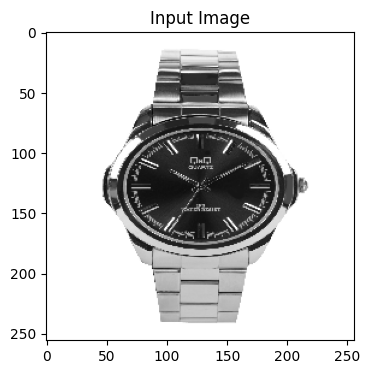

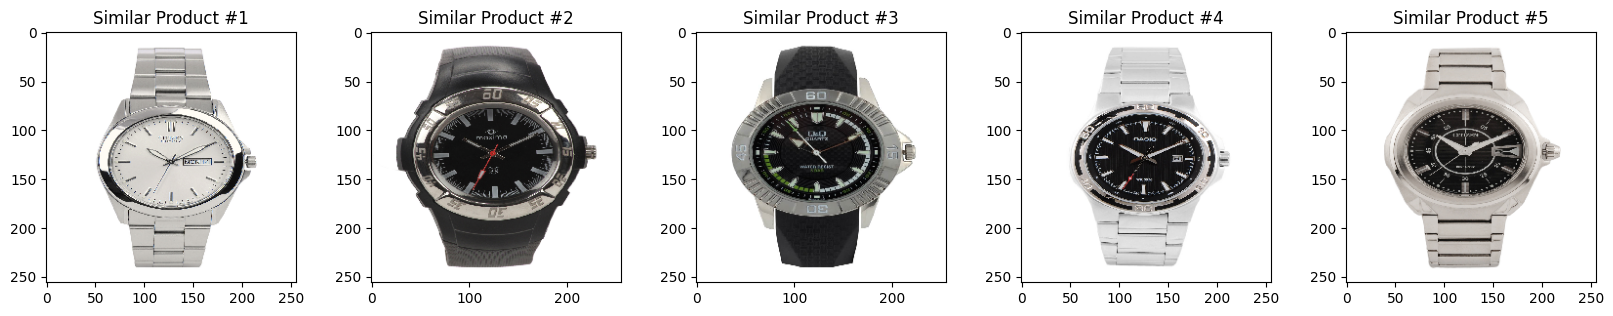

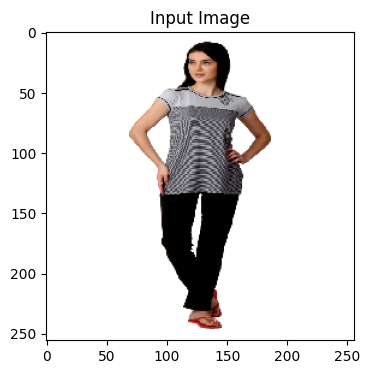

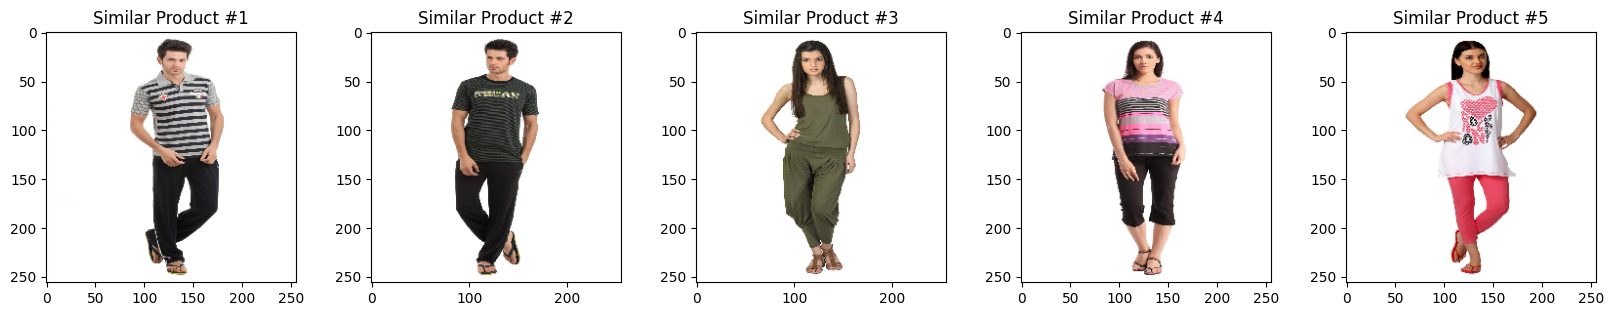

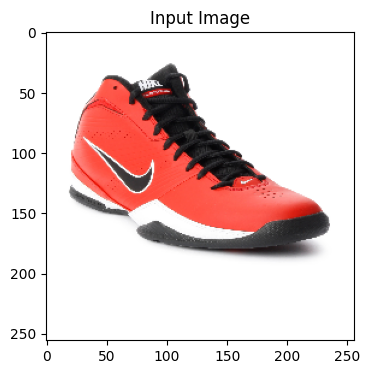

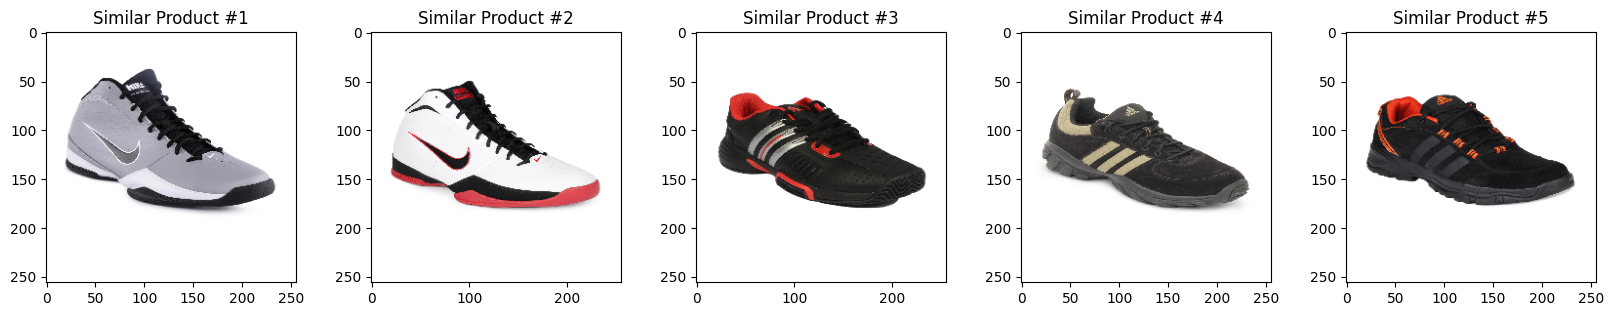

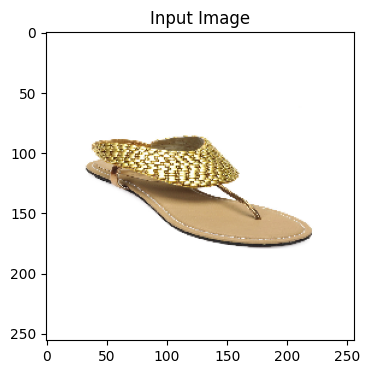

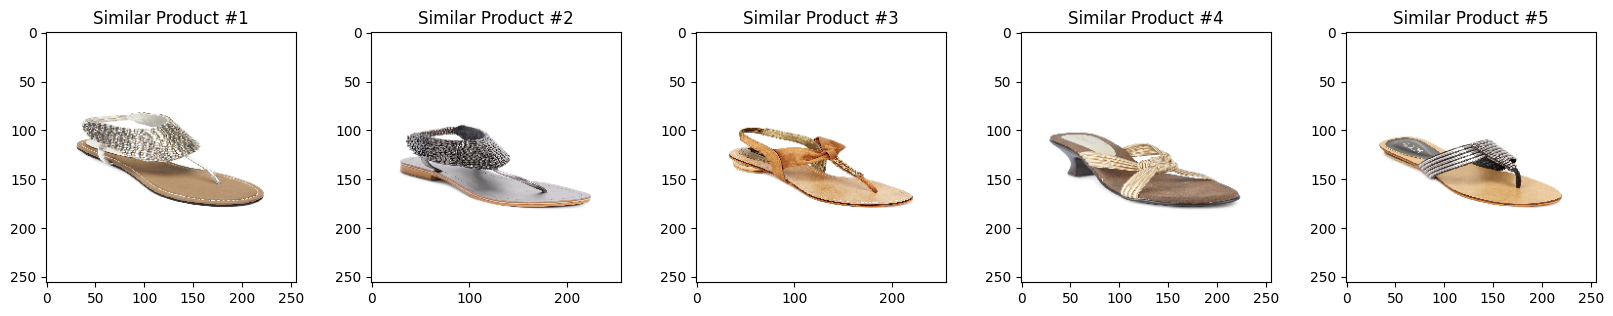

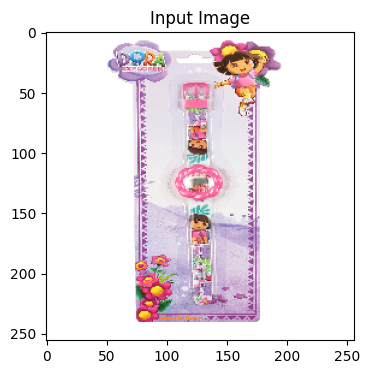

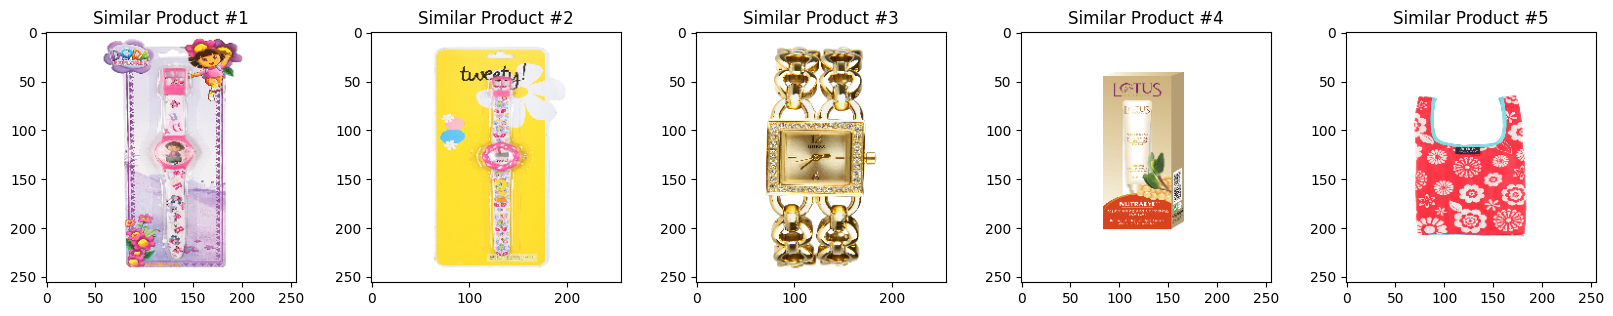

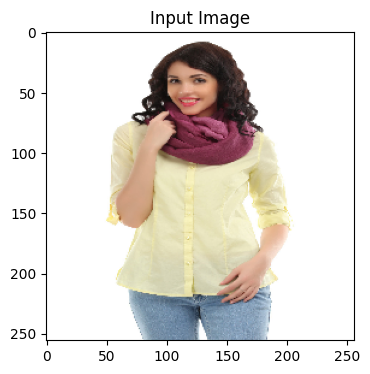

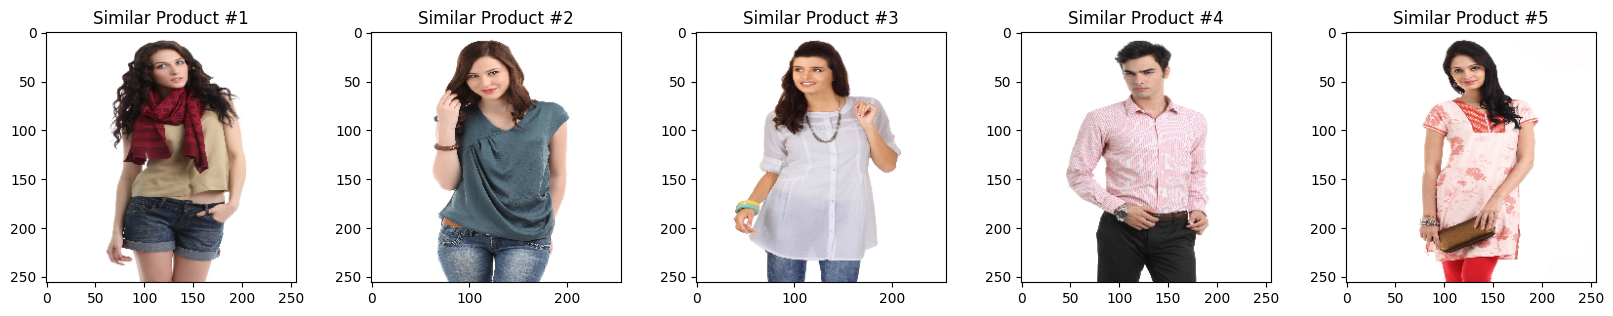

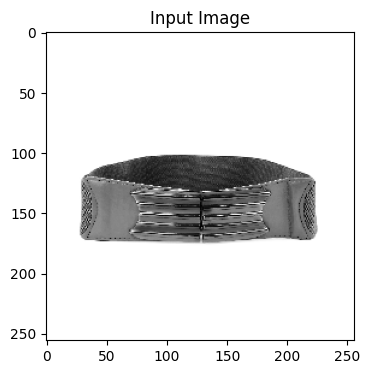

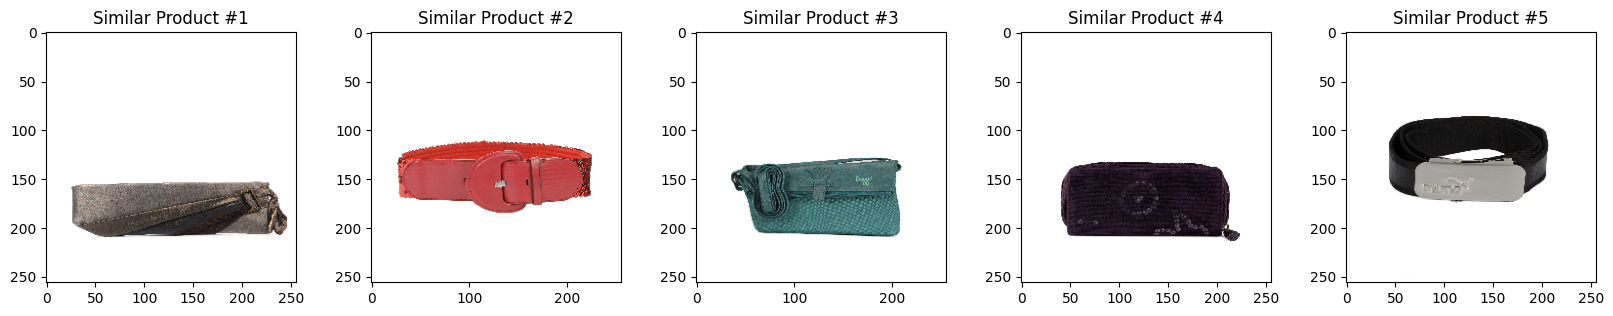

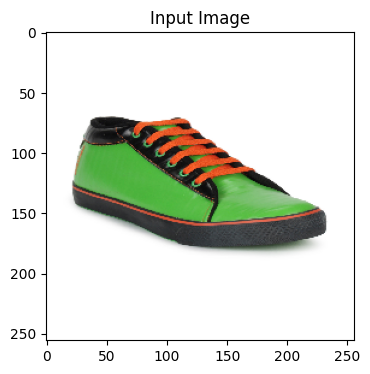

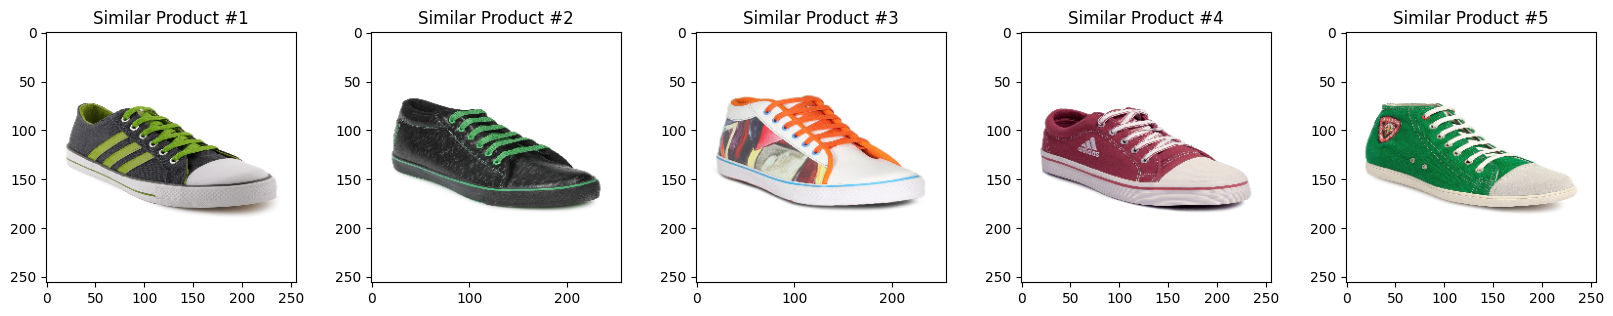

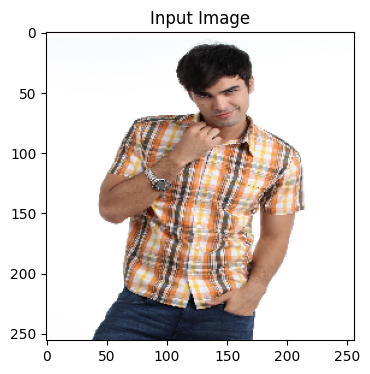

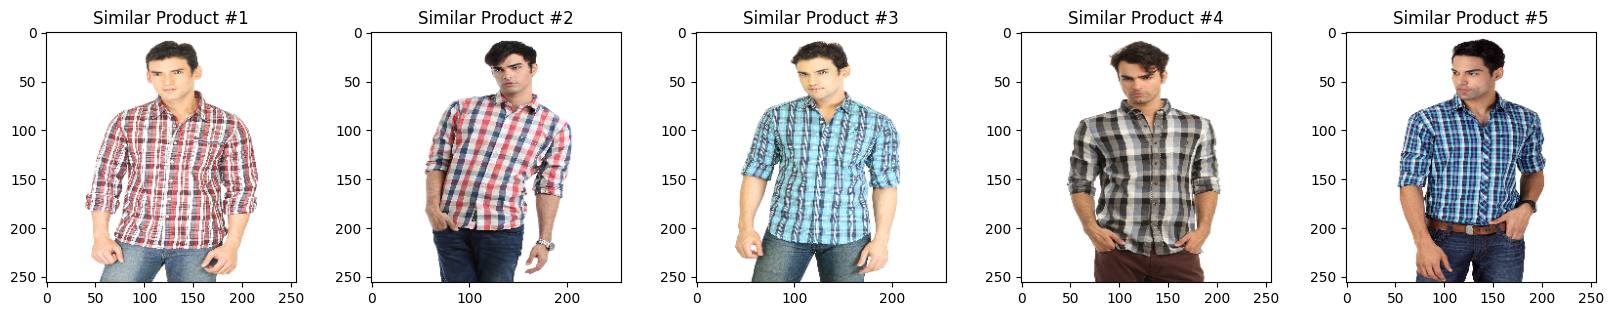

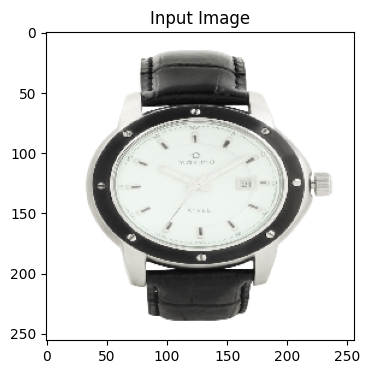

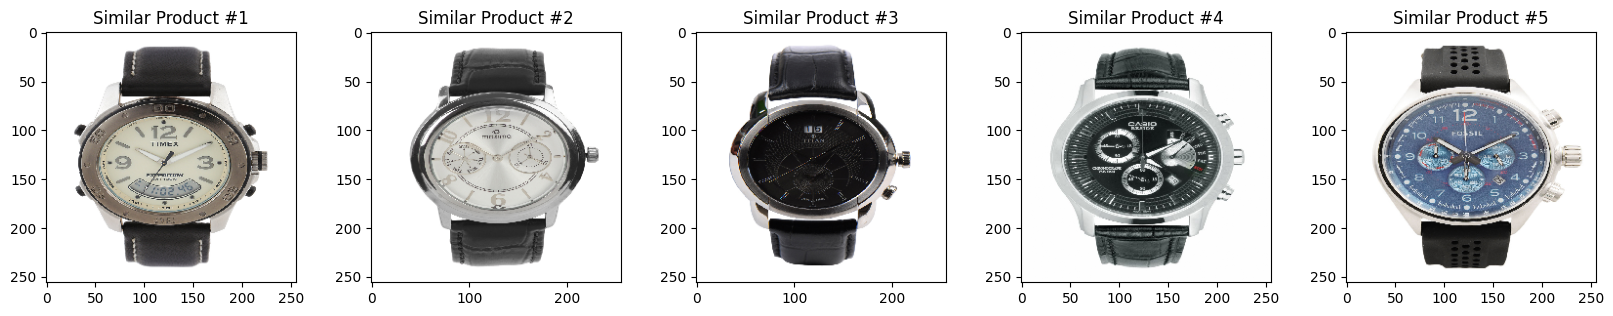

In [ ]:
for _ in range(10):
    i = random.randint(1,len(val))
    img1 = read_img(val.loc[i,'filename'])
    dist, index = neigh.kneighbors(X=X.iloc[i,:].values.reshape(1,-1))
    plt.figure(figsize = (4 , 4))
    plt.imshow(img1)
    plt.title("Input Image")

    plt.figure(figsize = (20 , 20))
    for i in range(1,6):
        plt.subplot(1 , 5, i)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        image = read_img(val.loc[index[0][i],'filename'])
        plt.imshow(image)
        plt.title(f'Similar Product #{i}')